In [1]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

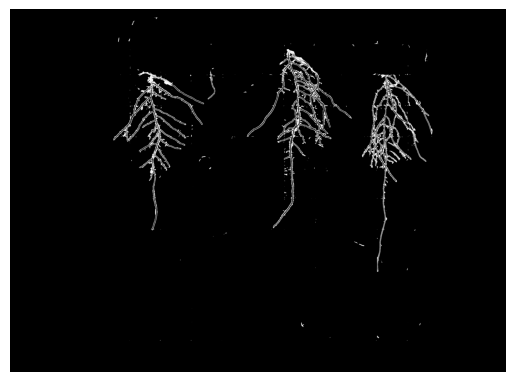

In [3]:
test_path = '/Volumes/T7/Artificial Intelligence/YEAR 2.1/Block B retake/task5/03_task5/task5_test_image_prediction_rayanedaborisova_220471.png'
test_loaded = cv2.imread(test_path, cv2.IMREAD_GRAYSCALE)

plt.imshow(test_loaded, cmap='gray')
plt.axis('off')
plt.show()

In [4]:
def close_small_gaps(mask, threshold=0.1, iterations=3, kernel_size=(5, 3)):
    binary = (mask > int(threshold * 255)).astype(np.uint8)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)
    closed = binary.copy()
    for _ in range(iterations):
        closed = cv2.morphologyEx(closed, cv2.MORPH_CLOSE, kernel)

    return closed

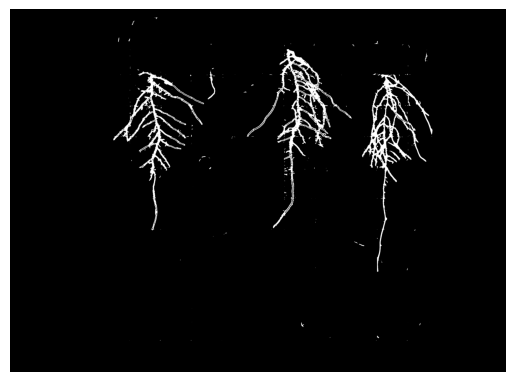

In [5]:
mask_closed = close_small_gaps(test_loaded, threshold=0.1)

plt.imshow(mask_closed, cmap='gray')
plt.axis('off')
plt.show()

In [6]:
def crop_empty_columns(mask, padding=20):
    """Remove empty columns on the sides (with an optional safety margin)."""
    occupied_columns = np.where(mask.sum(axis=0) > 0)[0]
    if occupied_columns.size == 0:                     # mask is all zeros
        return mask, (0, 0)

    left_crop  = max(occupied_columns[0] - padding, 0)
    right_crop = max(mask.shape[1] - occupied_columns[-1] - 1 - padding, 0)

    cropped_mask = mask[:, left_crop:mask.shape[1] - right_crop]
    return cropped_mask, (left_crop, right_crop)

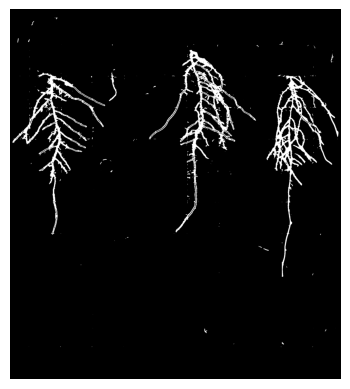

In [7]:
mask_cropped, (left_crop, right_crop) = crop_empty_columns(mask_closed, padding=20)

plt.imshow(mask_cropped, cmap='gray')
plt.axis('off')
plt.show()

In [8]:
def components_touch(mask_a, mask_b, max_px_dist=15):
    kernel = np.ones((max_px_dist * 2 + 1, max_px_dist * 2 + 1), dtype=np.uint8)
    dilated = cv2.dilate(mask_a.astype(np.uint8), kernel, iterations=1)
    return np.any(np.logical_and(dilated, mask_b))

In [9]:
def place_bands(cluster_masks, img_width, num_bands, min_px):
    band_width = img_width / num_bands
    bands = [np.zeros_like(cluster_masks[0], np.uint8)
             for _ in range(num_bands)]

    for cm in cluster_masks:
        if cm.sum() < min_px:
            continue
        x, y, w, h = cv2.boundingRect(cm)
        cx = x + w / 2.0
        band_idx = min(int(cx // band_width), num_bands - 1)
        bands[band_idx] |= cm

    return [(m * 255).astype(np.uint8) for m in bands]

In [10]:
 def segment_roots(mask, min_area=300, max_gap_px=20, num_roots=5, min_px_per_root=350):

    # connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask)
    comp_masks = [
        (labels == j).astype(np.uint8)
        for j in range(1, num_labels)
        if stats[j, cv2.CC_STAT_AREA] >= min_area
    ]
    if not comp_masks:
        blank = np.zeros_like(mask, np.uint8)
        return [blank.copy() for _ in range(num_roots)]

    # merge close comps
    merged, used = [], [False]*len(comp_masks)
    for i, m in enumerate(comp_masks):
        if used[i]:
            continue
        combo = m.copy()
        used[i] = True
        for j in range(i+1, len(comp_masks)):
            if not used[j] and components_touch(combo, comp_masks[j], max_gap_px):
                combo |= comp_masks[j]
                used[j] = True
        merged.append(combo)

    # K-means (≤ num_roots)
    boxes = np.array([cv2.boundingRect(m) for m in merged], np.float32)
    k = min(len(boxes), num_roots)
    lbl = KMeans(n_clusters=k, random_state=42, n_init="auto").fit_predict(boxes)

    cluster_masks = [np.zeros_like(mask, np.uint8) for _ in range(k)]
    for idx, m in enumerate(merged):
        cluster_masks[lbl[idx]] |= m

    # fixed-band mapping + padding
    return place_bands(cluster_masks,
                       img_width=mask.shape[1],
                       num_bands=num_roots,
                       min_px=min_px_per_root)

In [11]:
root_masks = segment_roots(mask_cropped)
print('Masks returned:', len(root_masks))

Masks returned: 5


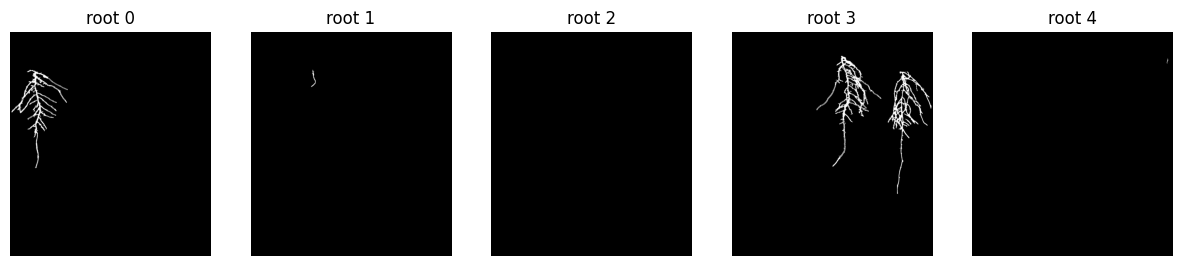

In [12]:
root1_mask, root2_mask, root3_mask, root4_mask, root5_mask = root_masks

plt.figure(figsize=(15, 5))
for i, m in enumerate(root_masks):
    plt.subplot(1, 5, i+1)
    plt.imshow(m, cmap='gray')
    plt.title(f'root {i}')
    plt.axis('off')
plt.show()

In [13]:
import os

save_dir = '/Volumes/T7/Artificial Intelligence/YEAR 2.1/Block B retake/task6/03_task6'

# Ensure the save directory exists
os.makedirs(save_dir, exist_ok=True)

# Save the entire figure with all root masks
fig, axs = plt.subplots(1, 5, figsize=(15, 5))

for i, m in enumerate(root_masks):
    axs[i].imshow(m, cmap='gray')
    axs[i].set_title(f"root {i}")
    axs[i].axis('off')

# Save the full figure to disk
full_figure_path = os.path.join(save_dir, "03_task6_roots.png")
plt.savefig(full_figure_path, bbox_inches='tight')
print(f"Saved combined figure: {full_figure_path}")
plt.close()


Saved combined figure: /Volumes/T7/Artificial Intelligence/YEAR 2.1/Block B retake/task6/03_task6/03_task6_roots.png
